In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd

In [ ]:
df=pd.read_pickle('/content/gdrive/MyDrive/malaya_fake_news_preprocessed_dataframe.pkl')

In [ ]:
df=df.head(15000)

In [ ]:
df.shape

(15000, 7)

In [ ]:
df.head()

,news,tokens,rejoined,length,label,real,fake
0,demi lovato telah jujur kejam tentang pertempu...,"[demi, lovato, telah, jujur, kejam, tentang, p...",demi lovato telah jujur kejam tentang pertempu...,448,1,1,0
1,selamat pagi inilah yang perlu anda ketahui se...,"[selamat, pagi, inilah, yang, perlu, anda, ket...",selamat pagi inilah yang perlu anda ketahui se...,682,1,1,0
2,tahniah untuk bintang glee lea michele pelakon...,"[tahniah, untuk, bintang, glee, lea, michele, ...",tahniah untuk bintang glee lea michele pelakon...,247,1,1,0
3,ia adalah satu kejutan yang mengejutkan untuk ...,"[ia, adalah, satu, kejutan, yang, mengejutkan,...",ia adalah satu kejutan yang mengejutkan untuk ...,718,1,1,0
4,transkrip minggu ini dengan george stephanopou...,"[transkrip, minggu, ini, dengan, george, steph...",transkrip minggu ini dengan george stephanopou...,668,1,1,0


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import seaborn as sns

Text(0.5, 1.0, 'Distribution of Fake - 0 /Real - 1 News')

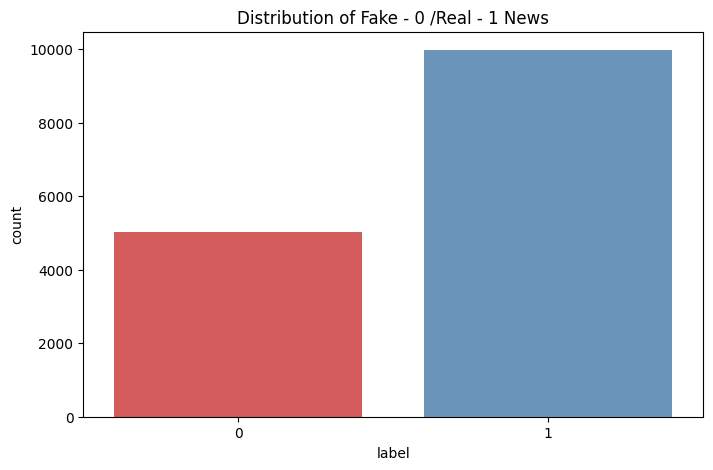

In [ ]:
df['num_words'] = df['news'].apply(lambda x: len(x.split()))
plt.figure(figsize = (8,5))
sns.countplot(x = df['label'], palette = 'Set1', alpha = 0.8)
plt.title('Distribution of Fake - 0 /Real - 1 News')

In [ ]:
target_count = df.label.value_counts()

In [ ]:
count_class_0, count_class_1 = df.label.value_counts()

# Divide by class
df_class_0 = df[df['label'] == 0]
df_class_1 = df[df['label'] == 1]

Random under-sampling:
1    5028
0    5028
Name: label, dtype: int64


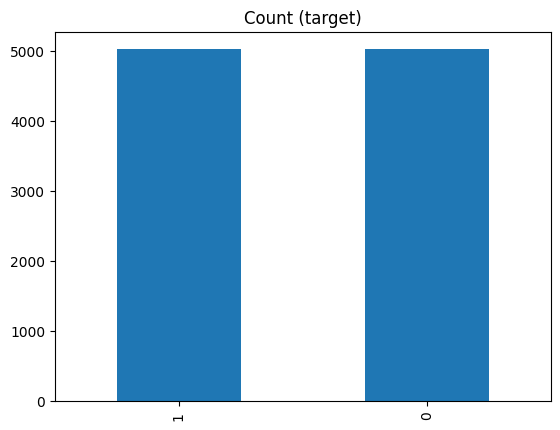

In [ ]:
df_class_1_under = df_class_1.sample(count_class_1)
df_test_under = pd.concat([df_class_1_under, df_class_0], axis=0)
#undersampling
print('Random under-sampling:')
print(df_test_under.label.value_counts())

df_test_under.label.value_counts().plot(kind='bar', title='Count (target)');

In [ ]:
df_test_under.shape

(10056, 8)

In [ ]:
dfnew=df_test_under[["news","label"]]

In [ ]:
dfnew.head()

,news,label
9203,kita semua telah menyaksikan siri netflix asli...,1
8537,"untuk orang lain dengan nama yang sama , lihat...",1
355,sesi jeff jeneral mengumumkan dia sedang meros...,1
13793,klik untuk menghantar e mel ini kepada seorang...,1
3472,teman lelaki lena dunham itu mempertahankannya...,1


In [ ]:
dfnew.shape

(10056, 2)

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 75.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 95.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 88.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 39.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import gc

from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from tensorflow.python.client import device_lib
from transformers import AutoTokenizer, TFBertModel

SEED = 10

In [ ]:
X=dfnew["news"]
y=dfnew["label"]

In [ ]:

MAX_LEN = 100

def get_model():
    dropout_rate = 0.2

    input_ids = Input(shape = (MAX_LEN,), dtype = tf.int32, name = 'input_ids')
    input_mask = Input(shape = (MAX_LEN,), dtype = tf.int32, name = 'input_mask')

    embeddings = bert([input_ids, input_mask])[1] #pooler output
    print(embeddings)

    out = Dropout(0.2)(embeddings)

    #64 units dense layer
    out = Dense(64,activation = 'relu')(out)
    out = Dropout(0.2)(out)

    y = Dense(1,activation = 'sigmoid')(out)

    model = Model(inputs=[input_ids, input_mask], outputs=y)
    model.layers[2].trainable = True

    #define optimizer
    optimizer = Adam(learning_rate=1e-05)

    #complile the model
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = 'accuracy')

    return model

#define tokenization function
def get_tokens(X):

    X = tokenizer(
                text = list(X),
                add_special_tokens = True,
                max_length = MAX_LEN,
                truncation = True,
                padding = True,
                return_tensors = 'tf',
                return_token_type_ids = False,
                return_attention_mask = True,
                verbose = True
                )

    return X

In [ ]:
from transformers import XLNetTokenizer, XLNetModel

In [ ]:
from transformers import XLNetTokenizer, XLNetForSequenceClassification

You are using a model of type xlnet to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFBertModel: ['transformer', 'lm_loss']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['bert']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


KerasTensor(type_spec=TensorSpec(shape=(None, 768), dtype=tf.float32, name=None), name='tf_bert_model/bert/pooler/dense/Tanh:0', description="created by layer 'tf_bert_model'")


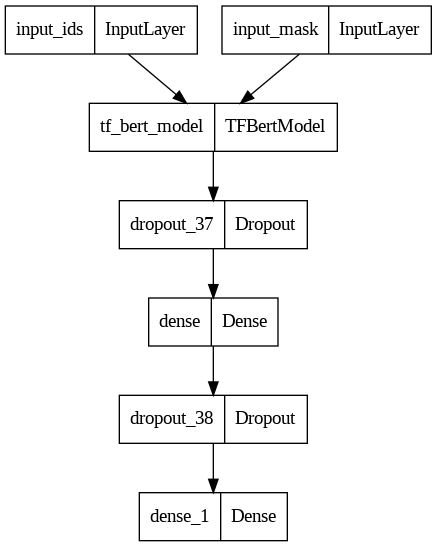

In [ ]:
#plot the model architecture
tokenizer = AutoTokenizer.from_pretrained('xlnet-base-cased')
bert = TFBertModel.from_pretrained('xlnet-base-cased')

model = get_model()
tf.keras.utils.plot_model(model)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = SEED)

In [ ]:
X_train_seq = get_tokens(X_train)
X_test_seq = get_tokens(X_test)

history = model.fit(x = {'input_ids':X_train_seq['input_ids'],'input_mask':X_train_seq['attention_mask']},
                    y = y_train, epochs=7,
                    validation_split = 0.2, batch_size = 32, callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=False,restore_best_weights=True)],workers=10)

Epoch 1/7
202/202 [==============================] - 199s 726ms/step - loss: 0.6906 - accuracy: 0.5299 - val_loss: 0.6921 - val_accuracy: 0.5078
Epoch 2/7
202/202 [==============================] - 149s 737ms/step - loss: 0.6668 - accuracy: 0.5717 - val_loss: 0.6585 - val_accuracy: 0.5749
Epoch 3/7
202/202 [==============================] - 148s 735ms/step - loss: 0.6345 - accuracy: 0.6068 - val_loss: 0.6105 - val_accuracy: 0.6513
Epoch 4/7
202/202 [==============================] - 139s 686ms/step - loss: 0.5393 - accuracy: 0.7285 - val_loss: 0.4909 - val_accuracy: 0.7707
Epoch 5/7
202/202 [==============================] - 139s 687ms/step - loss: 0.4618 - accuracy: 0.7840 - val_loss: 0.4731 - val_accuracy: 0.7850
Epoch 6/7
202/202 [==============================] - 148s 731ms/step - loss: 0.4012 - accuracy: 0.8159 - val_loss: 0.4744 - val_accuracy: 0.7657
Epoch 7/7
202/202 [==============================] - 148s 735ms/step - loss: 0.3823 - accuracy: 0.8227 - val_loss: 0.4513 - val_ac

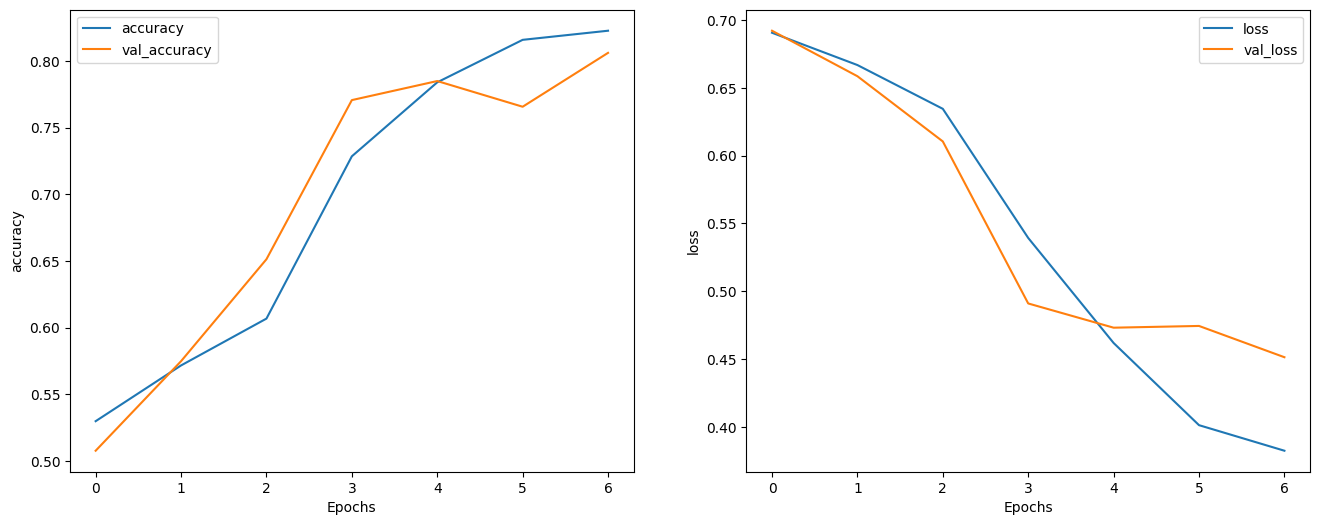

In [ ]:
def plot_graphs(history, metric):

    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])


plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [ ]:
yhat =  np.where(model.predict({'input_ids':X_test_seq['input_ids'],'input_mask':X_test_seq['attention_mask']}) >=0.5,1,0)

63/63 [==============================] - 16s 215ms/step


In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
print("precision score:",precision_score(y_test,yhat))
print("recall score:",recall_score(y_test,yhat))
print("accuracy score:",accuracy_score(y_test,yhat))
print("f1 score:",f1_score(y_test,yhat))


precision score: 0.7614761476147615
recall score: 0.8409542743538767
accuracy score: 0.7887673956262425
f1 score: 0.7992442135096834


In [ ]:
print(classification_report(y_test,yhat))

              precision    recall  f1-score   support

           0       0.82      0.74      0.78      1006
           1       0.76      0.84      0.80      1006

    accuracy                           0.79      2012
   macro avg       0.79      0.79      0.79      2012
weighted avg       0.79      0.79      0.79      2012



Text(70.72222222222221, 0.5, 'Real Labels')

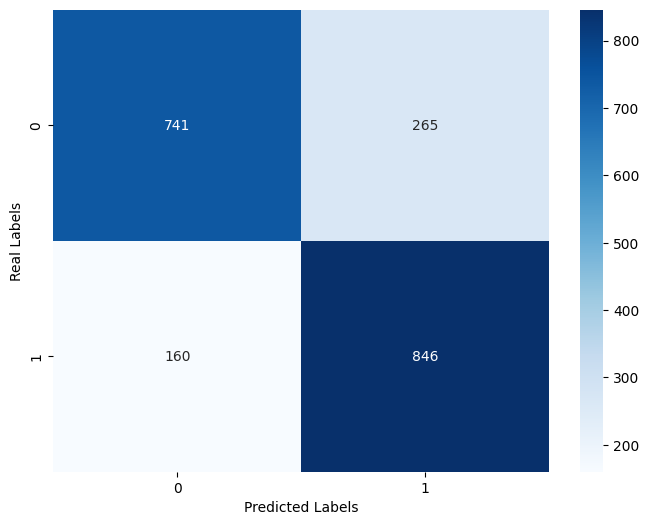

In [ ]:
plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(y_test,yhat), annot=True,
            fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')

In [ ]:
import tensorflow as tf

In [ ]:
model.save("xlnet.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
